# D-AT-GRU
## Imports

In [1]:
import itertools
import more_itertools as mit
import math
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.utils.data.dataloader as dataloader
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from semeval2014.semeval_base import *

from nltk.tokenize import TweetTokenizer

from torchviz import make_dot

## Hyper Paramètres

## Load Dataset

In [2]:
trainfile="semeval2014/restaurants-trial.xml"
testfile="semeval2014/Restaurants_Test_Data_PhaseA.xml"
corpus = Corpus(ET.parse(trainfile).getroot().findall('sentence'))
unseen = Corpus(ET.parse(testfile).getroot().findall('sentence'))
b1 = BaselineAspectExtractor(corpus)
predicted = b1.tag(unseen.corpus)
corpus.write_out('test.predicted-aspect.xml', predicted, short=False)

## Show 10 sentences and categories example in train

In [3]:
for index, sentence in zip(range(10), corpus.corpus):
    print(sentence.text)
    for categorie in sentence.aspect_categories:
        print(categorie.term, categorie.polarity)
    print("")

All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!
food positive

And really large portions.
food positive

Go inside and you won't want to leave.
anecdotes/miscellaneous positive

Save yourself the time and trouble and skip this one!
anecdotes/miscellaneous negative

The sweet lassi was excellent as was the lamb chettinad and the garlic naan but the rasamalai was forgettable.
food conflict

Service was quick.
service positive

Oh, don't even let me start with how expensive the bills were!
price negative

Service is top notch.
service positive

The best thing I tasted were the lambc hops.
food positive

Overall I would recommend it and go back again.
anecdotes/miscellaneous positive



## Load Pre-trained Embedding Vectors from Glove (little dataset)

In [18]:
embeddings_dict = {}
embedding_dim=300
with open("embeddings/glove.6B."+ str(embedding_dim) +"d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

## Exemple d'embedding

In [19]:
print(embeddings_dict['cat'])

[-0.29353    0.33247   -0.047372  -0.12247    0.071956  -0.23408
 -0.06238   -0.0037192 -0.39462   -0.69411    0.36731   -0.12141
 -0.044485  -0.15268    0.34864    0.22926    0.54361    0.25215
  0.097972  -0.087305   0.87058   -0.12211   -0.079825   0.28712
 -0.68563   -0.27265    0.22056   -0.75752    0.56293    0.091377
 -0.71004   -0.3142    -0.56826   -0.26684   -0.60102    0.26959
 -0.17992    0.10701   -0.57858    0.38161   -0.67127    0.10927
  0.079426   0.022372  -0.081147   0.011182   0.67089   -0.19094
 -0.33676   -0.48471   -0.35406   -0.15209    0.44503    0.46385
  0.38409    0.045081  -0.59079    0.21763    0.38576   -0.44567
  0.009332   0.442      0.097062   0.38005   -0.11881   -0.42718
 -0.31005   -0.025058   0.12689   -0.13468    0.11976    0.76253
  0.2524    -0.26934    0.068629  -0.10071    0.011066  -0.18532
  0.44983   -0.57507    0.12278   -0.064878   0.044456  -0.020999
 -0.069838  -0.47329   -0.43074    0.39158   -0.047815  -0.93659
 -0.55128   -0.1422    

### Prepare glove embeddings for pytorch

In [20]:
# Get training vocab length
tknzr = TweetTokenizer() # Use tweetTokenizer because of the internet review style
vocab = {}
vocab[''] = 0 # Padding
vocab['oov'] = 1 # out of Vocabulary
for sentence in corpus.corpus:
    for word in tknzr.tokenize(sentence.text):
        if word not in vocab:
            vocab[word] = len(vocab)

# Prepare embeddings vocab matrix
pretrained_embeds = np.zeros((len(vocab), embedding_dim))
oov_embed = np.random.normal(scale=0.5, size=(embedding_dim, ))
for i, word in enumerate(vocab):
    try: 
        pretrained_embeds[i] = embeddings_dict[word]
    except KeyError:
        pretrained_embeds[i] = oov_embed

## Aspects Extractions

In [21]:
# Get training aspects
aspects = {}
for sentence in corpus.corpus:     
    for aspect in sentence.aspect_categories:
        if aspect.term not in aspects:
            aspects[aspect.term] = len(aspects)

## Function to transform polarity to number

In [22]:
def to_polarity(polarity):
    if polarity == 'positive':
        return 0
    elif polarity == 'negative':
        return 1
    elif polarity == 'conflict':
        return 2
    else:
        return 3

## Transform dataset to tensor dataset

In [23]:
def to_tensordataset(corpus, dictionary, aspects, batch_size):
    res = []
    for sentence in corpus.corpus:     
        for aspect in sentence.aspect_categories:
            res.append(([dictionary[word] if word in dictionary else 1 for word in tknzr.tokenize(sentence.text)], aspects[aspect.term], to_polarity(aspect.polarity)))
    random.shuffle(res)
    res = [res[x:x+batch_size] for x in range(0, len(res), batch_size)]
    batched_result = []
    for batch in res:
        a,b,c = list(map(list, zip(*batch)))
        max_len = 0
        for elt in a:
            if len(elt) > max_len:
                max_len = len(elt)
        
        a = torch.tensor([list(mit.padded(elt, 0, max_len)) for elt in a], dtype=torch.long)
        b = torch.tensor(b, dtype=torch.long).flatten()
        c = torch.tensor(c, dtype=torch.int).flatten()
        batched_result.append((a,b,c))
    return batched_result

## D-AT-GRU Model

In [24]:
class D_AT_GRU(nn.Module):
    def __init__(self, pretrained_embeds, aspects_number):
        super(D_AT_GRU, self).__init__() 
        hidden_size=300
        num_layers=1
        bias=True
        batch_first=True
        aspect_size=300
        vocab_size, embed_dim = pretrained_embeds.shape
        
        # Load Glove embeddings
        self.word_embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.word_embeddings.from_pretrained(torch.FloatTensor(pretrained_embeds))

        # Init GRU 
        self.gru = nn.GRU(input_size= embed_dim, hidden_size= hidden_size,  
                          num_layers= num_layers, bias= bias, 
                          batch_first= batch_first, bidirectional=False)

        # Init random aspects embeddings
        self.aspect_embeddings = nn.Embedding.from_pretrained(self.init_random(aspects_number, aspect_size))

        # Init positive attention
        self.W_p = Parameter(self.init_random(hidden_size, hidden_size + aspect_size))
        self.b_p = Parameter(self.init_random(hidden_size, 1)).squeeze()
        self.u_p = Parameter(self.init_random(hidden_size, 1))

        # Init negative attention
        self.W_n = Parameter(self.init_random(hidden_size, hidden_size + aspect_size))
        self.b_n = Parameter(self.init_random(hidden_size, 1)).squeeze()
        self.u_n = Parameter(self.init_random(hidden_size, 1))

        # Init gates
        self.W_py = Parameter(self.init_random(1, hidden_size + aspect_size))
        self.b_py = Parameter(self.init_random(1, 1).squeeze())
        self.W_ny = Parameter(self.init_random(1, hidden_size + aspect_size))
        self.b_ny = Parameter(self.init_random(1, 1).squeeze())

        # Softmax function
        self.softmax = nn.Softmax(dim=1)

        # Identity matrix
        self.I = torch.eye(128,128)

    def forward(self, sentence, aspect):    
        batch_size = sentence.size()[0]
        sentence_length = sentence.size()[1]  
        
        word_embedding = self.word_embeddings(sentence)   
        hidden_state, _ = self.gru(word_embedding)
        aspect_embedding = self.aspect_embeddings(aspect)

        # Resize aspect embedding for sentence length in batch
        aspect_embedding = aspect_embedding.unsqueeze_(1)
        aspect_embedding = aspect_embedding.expand(-1, sentence_length, -1) 

        # Concat hidden_state and aspect_embedding for attention calculation
        hidden_plus_aspect = torch.cat((hidden_state, aspect_embedding), dim=2)

        # Positive attention calculation
        positive_attention = torch.tanh(F.linear(hidden_plus_aspect, self.W_p) + self.b_p)
        positive_attention = F.linear(positive_attention, self.u_p.t())
        # Remove 3-dim and transpose to get (sentence_length, batch_size)
        positive_attention = positive_attention.squeeze(2)
        # Attention calculation for each word in sentence 
        positive_attention = self.softmax(positive_attention).unsqueeze(1)

        # Negative attention calculation
        negative_attention = torch.tanh(F.linear(hidden_plus_aspect, self.W_n) + self.b_n)
        negative_attention = F.linear(negative_attention, self.u_n.t())
        # Remove 3-dim and transpose to get (sentence_length, batch_size)
        negative_attention = negative_attention.squeeze(2)
        # Attention calculation for each word in sentence
        negative_attention = self.softmax(negative_attention).unsqueeze(1)

        # Text representation: Gate mechanism
        positive_gate = torch.bmm(positive_attention, hidden_state).squeeze(1)
        negative_gate = torch.bmm(negative_attention, hidden_state).squeeze(1)
        
        # Classification layer
        positive_layer = F.linear(torch.cat((positive_gate, self.aspect_embeddings(aspect).squeeze(1)), dim=1), self.W_py, self.b_py)
        negative_layer = F.linear(torch.cat((negative_gate, self.aspect_embeddings(aspect).squeeze(1)), dim=1), self.W_ny, self.b_ny)
        classification = torch.cat((positive_layer, negative_layer), dim=1)

        # Regularization
        regularization = torch.cat((positive_attention, negative_attention), dim=1)
        regularization = torch.bmm(regularization.permute(0, 2, 1), regularization) 
        regularization = regularization - self.I[:sentence_length,:sentence_length].expand(regularization.size(0), -1, -1)
        loss = torch.norm(regularization) / sentence_length

        return classification, loss

    def init_random(self, x_size, ysize):
        empty = torch.empty(x_size, ysize, dtype=torch.float32, requires_grad=True)
        return nn.init.normal_(empty, mean=0, std=0.01)

## Label transformation (post-processing)

In [25]:
def label_tranformation(predictions, P=0.5):
    result = []
    for prediction in predictions:
        y_p = prediction[0].item()
        y_n = prediction[1].item()
        if y_p > P and y_n > P:
            result.append([0,0,1,0])
        elif y_p <= P and y_n <= P:
            result.append([0,0,0,1])
        elif y_p <= P and y_n > P:
            result.append([0,1,0,0])
        else:
            result.append([1,0,0,0])
    return torch.FloatTensor(result)

## Training cycle

In [26]:
def train(model, dataset, lr, num_epochs):
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    model.train()
    losses_average = []    
    for epoch in range(1,num_epochs+1):       
        # Remise à zéro des gradients
        optimizer.zero_grad()
        batch_idx = 0
        epoch_losses = []
        for data, aspect, target in dataset:
            batch_idx += 1
            # Get Samples
            data, aspect, target = Variable(data), Variable(aspect), Variable(target)
            
            # Prédiction
            pred, loss = model(data, aspect)

            # Calculer la cross_entropy loss
            # TODO

            # Sauvegarde des losses pour affichage
            epoch_losses.append(loss.data.item())

            # Backpropagation
            loss.backward(retain_graph=True)
            optimizer.step()
                      
            # Affichage
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(epoch,batch_idx * len(data),len(dataset)*len(data),100. * batch_idx / len(dataset), np.average(epoch_losses)), end='')
        print()
        losses_average.append(np.average(epoch_losses))
    print("Evolution of average losse for each epoch:")
    plt.plot(losses_average)
    plt.show()
    return model

 Train Epoch: 1 [48/48 (100%)]	 Loss: 0.630140
 Train Epoch: 2 [48/48 (100%)]	 Loss: 0.623917
 Train Epoch: 3 [48/48 (100%)]	 Loss: 0.625569
 Train Epoch: 4 [48/48 (100%)]	 Loss: 0.624446
 Train Epoch: 5 [48/48 (100%)]	 Loss: 0.626133
 Train Epoch: 6 [48/48 (100%)]	 Loss: 0.624798
 Train Epoch: 7 [48/48 (100%)]	 Loss: 0.623529
 Train Epoch: 8 [48/48 (100%)]	 Loss: 0.623503
 Train Epoch: 9 [48/48 (100%)]	 Loss: 0.623494
 Train Epoch: 10 [48/48 (100%)]	 Loss: 0.623493
 Train Epoch: 11 [48/48 (100%)]	 Loss: 0.623493
 Train Epoch: 12 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 13 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 14 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 15 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 16 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 17 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 18 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 19 [48/48 (100%)]	 Loss: 0.623492
 Train Epoch: 20 [48/48 (100%)]	 Loss: 0.623492
Evolution of average losse for each epoch:


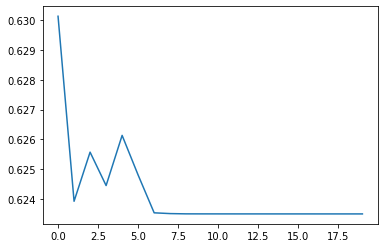

D_AT_GRU(
  (word_embeddings): Embedding(479, 300, padding_idx=0)
  (gru): GRU(300, 300, batch_first=True)
  (aspect_embeddings): Embedding(5, 300)
  (softmax): Softmax(dim=1)
)

In [27]:
train(D_AT_GRU(pretrained_embeds, len(aspects)), to_tensordataset(corpus, vocab, aspects, 10), 0.01, 20)